### Hidden Marcov Model (HMM)
#### Identification of CG-rich regions of the genome with Pomegranate

Acording to Pomegranate docs by Jacob Schreiber

A good introduction to HMM is YouTube, Normalized Nerd: Hidden Markov Model Clearly Explained! Part-5
 

**The problem:** We have a sequence of DNA nucleotides Adenine, Cytocine, Guanine and Thymine (A, C, G, T). We want to find CG-rich regions in that sequence if there are any. Our sequence is \
S = 'CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC'.



In [1]:
import seaborn; seaborn.set_style('whitegrid')
import torch

from pomegranate.bayes_classifier import BayesClassifier
from pomegranate.distributions import *

import numpy
numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%matplotlib inline 
import matplotlib.pyplot as plt



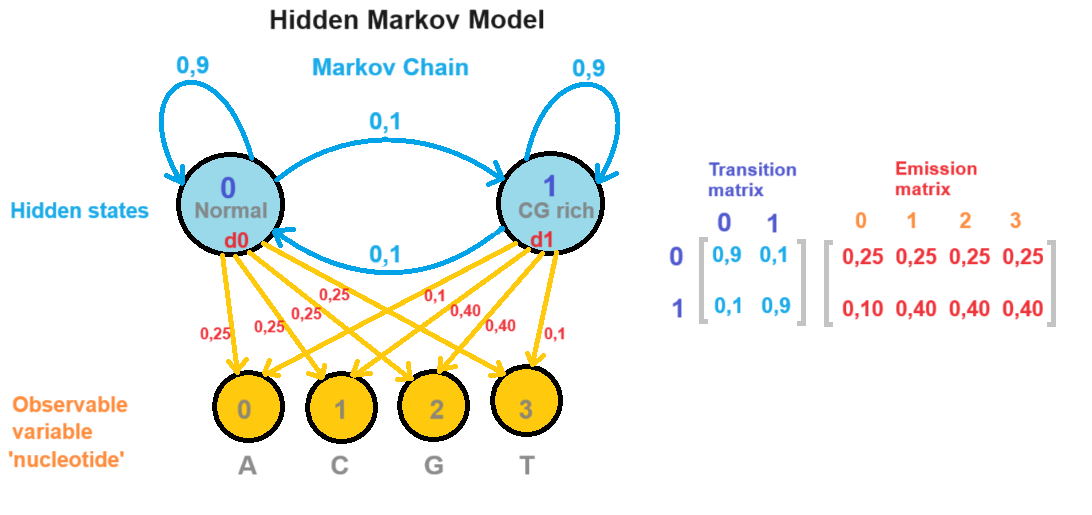


We can imagine that the ACTG-chain producing mechanism works in two different modes (blue Markov Chain), the basic mode (0) and the CG abundant chain-producing mode (1). In basic mode, the machine produces each letter A,C,G,T with the same probability of 0.25 (distribution d0). In the 'CG' mode, the probability of producing C or G next is 0.4 + 0.4 = 0.8 (distribution d1). The distribution d1 also gives a small probability that the letters A and T can occur randomly even in an area rich in CG.

The machine jumps randomly from one mode to another with a small probability of 0,1. The sequence of the machine's modes is hidden from us, and several sequences of modes could enable the observed nucleotide sequence S. Pomegranate calculates for us the hidden sequence of these modes that most likely produces the observed ACGT-sequence S. From the output sequence we can then easilly see if there are islands of state 1 modes i.e. CG rich areas. 

**Transition matrix** gives the probability of going from one hidden state to the next hidden state.
**Emission matrix** gives the probabilities of producing the next letter in the ACTH sequence in a given state. Both hidden states (0, 1) have their own probability distribution (d0, d1) for the letters.


**Note.**  The comparison with nucleotide production operating in different modes is not biologically valid because the enzyme machinery in the cell only copies the existing, evolutionarily modified DNA genome. But hopefully the comparison helps to see why HMM is relevant in this context.



In [2]:
from pomegranate.distributions import Categorical
#                   A     C     G     T
d0 = Categorical([[0.25, 0.25, 0.25, 0.25]]) # 'Normal'  hidden state (0) (uniform distribution)
d1 = Categorical([[0.10, 0.40, 0.40, 0.10]]) # 'CG rich' hidden state (1) (preference for C and G)

Now we can create the model HMM. 

In [3]:
from pomegranate.hmm import DenseHMM   # For a dense transition matrix 

model = DenseHMM()                   
# In Pomegranate 1.0 Markov Chain the nodes come directly from the list of distributions and 
# edges are defined from the transition matrix. No need for explicite definitions for them.
model = DenseHMM([d0, d1], edges=[[0.9, 0.1], [0.1, 0.9]], starts=[0.5, 0.5])

In [4]:
S = 'CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC'

# This sequence is converted into a numerical representation [0, 1, 2, 3] of the categories:
X =  numpy.array([[[['A', 'C', 'G', 'T'].index(char)] for char in S]])
print(X[0].T)
X.shape       #--> (batch_size = 1, sequence length = 51, dimensionality = 1) 


[[1 2 0 1 3 0 1 3 2 0 1 3 0 1 3 1 2 1 1 2 0 1 2 1 2 0 1 3 2 1 1 2 3 1 3 0
  3 0 1 3 2 1 2 1 0 3 0 1 2 2 1]]


(1, 51, 1)

Now we can make prediction on our sequence S. 

In [5]:
y_hat = model.predict(X)

print("sequence S: {}".format(''.join(S)))
print("hmm pred:   {}".format(''.join([str(y.item()) for y in y_hat[0]])))
# '.item' extracts the value from a torch tensor

sequence S: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred:   000000000000000111111111111111100000000000000001111


The prediction 'y_hat' gives the most probable sequence of hidden states to produce the given sequence S. We can see that the model wasn’t tricked into thinking that every CG or even pair of CGs was an island. It required many C’s and G’s to be part of a longer stretch to identify that region as an island. We can also see that the model has accepted some random letters A and T inside the CG abundant region. Naturally, the balance of the transition and emission probabilities will heavily influence what regions are detected.


Hidden Markov models can also provide probability estimates of class assignments instead of just hard labels. These estimates are the posterior probabilities of belonging to each of the hidden states given the observation, but also given the rest of the sequence.

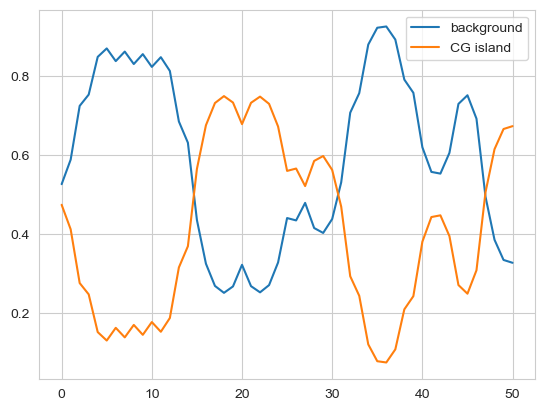

In [6]:
plt.plot(model.predict_proba(X)[0], label=['background', 'CG island'])
plt.legend()
plt.show()

The sequence S is numbered on the x-axis. These estimates are the posterior probabilities of belonging to each of the hidden states given the observation, but also given the rest of the sequence. The predict method is just taking the most likely element — the maximum-a-posteriori estimate.

In [9]:
# Here are the calculated probabilities for some individual letters  from the begin to belong 
# either to the background or to a CG-rich area (their sum is 1). 
print(model.predict_proba(X)[0][0:19])


tensor([[0.5261, 0.4739],
        [0.5881, 0.4119],
        [0.7242, 0.2758],
        [0.7528, 0.2472],
        [0.8483, 0.1517],
        [0.8697, 0.1303],
        [0.8375, 0.1625],
        [0.8617, 0.1383],
        [0.8301, 0.1698],
        [0.8552, 0.1448],
        [0.8229, 0.1771],
        [0.8475, 0.1525],
        [0.8126, 0.1874],
        [0.6847, 0.3153],
        [0.6310, 0.3690],
        [0.4354, 0.5646],
        [0.3248, 0.6752],
        [0.2686, 0.7314],
        [0.2510, 0.7490]])


In [8]:
# The probability that the 13. letter 'A' belongs to CG rich area
print(model.predict_proba(X)[0][12][1].item())  # '.item' extracts the value from a torch tensor


0.1873762160539627
